## Setup and Data Preparation

In [12]:
# Load IPython autoreload extension to automatically reload external modules (for development convenience)
%load_ext autoreload
%autoreload 2

# Import essential libraries for data handling and computations
import pandas as pd                    # Data frames and CSV I/O
import numpy as np                     # Numerical computing (arrays, math)
from tqdm import tqdm                  # Progress bar for loops
import tkinter                         # GUI toolkit (possibly used by matplotlib or ignored in headless mode)

# Import plotting tools for visualizing data (if needed)
import matplotlib.pyplot as plt       
%matplotlib inline                     # Display plots inline in the Jupyter notebook

# Import PyTorch utilities and PyTorch Geometric (for graph-based data)
import torch.utils.data                # Data utilities for PyTorch
from torch_geometric.data import Data  # Data structure for graph data (nodes, edges, features)
from torch.utils.tensorboard import SummaryWriter  # Logging for TensorBoard
import scipy.io as io                  # For MATLAB .mat file I/O (not heavily used here)

# Import custom Evolution Strategy optimizers (likely implementations of GA, CMA-ES, etc.)
from es import SimpleGA, CMAES, PEPG, OpenES

# Import other libraries and custom modules for the project
from torchvision import transforms     # Image transforms (not crucial here, possibly for data augmentation)
from entropy import sample_entropy     # Custom module to compute entropy/metrics in latent space
import classGridDataset                # Custom dataset class for grid data (likely handles graph creation)
import useful_custom_functions         # Assorted helper functions (custom)
from grid import show_grid, load_grid, Graph_to_Grid  # Utilities to visualize grid or convert graph data back to grid format
from models import FC_selu_first       # A model architecture (possibly unused here, included for completeness)
from GVWAE import *                    # Import everything from Graph Variational Autoencoder module (GVWAE)
from data import *                     # Import data processing functions (e.g., normalization, etc.)
import wandb                           # Weights & Biases for experiment tracking
wandb_run = wandb.init(project='es', entity='hits')  # Initialize a W&B run for logging metrics

import os
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'  # Environment setting to help debug CUDA (ensures synchronous GPU ops)

from data import get_dataset           # Function to load dataset (may not be used explicitly if dataset loaded via pickle)
from torch_geometric.data import DataLoader  # DataLoader for batching graph data
from curve import connecting_geodesic, linear_interpolation  # Tools for latent space interpolation (geodesics in latent space)
from smoothness import smoothness_factor_simple, plot_smoothness  # Tools to assess smoothness of generated fields (not used directly here)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
# Load the pre-processed dataset of geological scenarios from a pickle file
import pickle 
with open('dataset.pickle', 'rb') as f:
    dataset_list = pickle.load(f)

In [ ]:
# Apply transformations to the dataset (e.g., normalization of features)
dataset_list, transformer, max0 = transform_dataset(dataset_list) 

## Generative Model Loading and Latent Encoding

In [17]:
# Set up parameters for the generative model (Graph-based Variational Autoencoder)
mu_epochs = 50        # (If training were done) epochs to train the mean of distribution (not used in inference here)
sigma_epochs = 1      # Epochs to train the covariance (if applicable; likely not used in this inference notebook)
batch_size = 1        # Batch size for loading data (one graph at a time due to variable graph sizes or memory limits)
nv = 1919             # Number of vertices (graph nodes) in each scenario's graph (active cells in the reservoir grid)
nz = 30               # Latent space dimension (size of the code z representing each scenario)
writer = SummaryWriter()  # TensorBoard writer for logging (if training, to log losses etc.)

In [18]:
# Prepare a data loader for the dataset (not extensively used for training here, but to retrieve graph structure)
train_loader = DataLoader(dataset_list, batch_size=batch_size, shuffle=True)

In [19]:
# Initialize the Trainer (Graph VAE model) with the same parameters used in training
trainer = TrainerRBF(batch_size=batch_size, nv=nv, nz=nz, model_loss='mmd',
                     gamma=1, channels=2, num_centers=1000, edge_index=next(iter(train_loader)).edge_index, 
                     writer=writer, middle_layer_size=500, middle_channels=8, warmup_learning_rate=1e-3, 
                     sigma_learning_rate=1e-3)

In [20]:
# Load the pre-trained model weights from file (trained Graph VAE)
trainer.model.load_state_dict(torch.load('rvae.pt'))

<All keys matched successfully>

In [21]:
# Encode all dataset realizations into their latent vectors for analysis
zs = []            # list to collect latent codes
pore_vols_hist = []  # (optional) list to collect pore volume for each scenario, not used actively here
for data in tqdm(dataset_list):
    z, q_mu, q_var = trainer.model.encode(data.x, 1)
    zs.append(z.detach().cpu().numpy())
    # pore_vols_hist.append(np.sum(data.x[:,0].cpu().numpy()*max_poro))  # Example: compute pore volume (if needed)
zs = np.array(zs)

100%|█████████████████████████████████████████████████████████████████████████████| 5000/5000 [00:13<00:00, 369.55it/s]


In [ ]:
# Compute statistics of the latent space distribution (to guide optimization initialization)
zs_mean = np.mean(zs, axis=0)
zs_std = np.std(zs, axis=0)
zs_mean.shape, zs_std.shape  # e.g., (1, 30) for both mean and std

<ipython-input-36-bb08b079701f>:23: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_res, _ = trainer.model.decode(torch.reshape(torch.tensor(z_1945).to(device).float(), (1,30)), False)


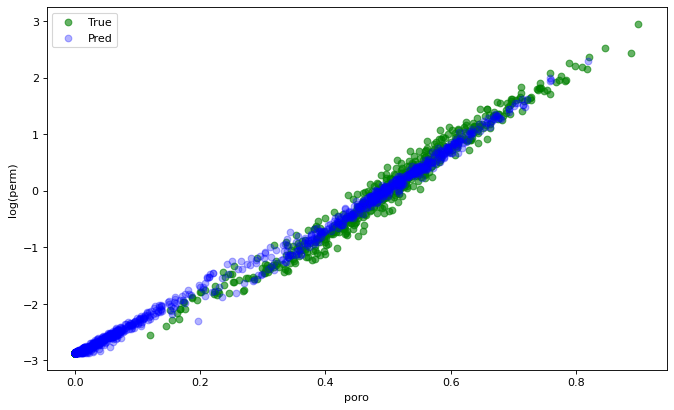

In [36]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


%matplotlib inline
figure(figsize=(10, 6), dpi=80)


por_t = dataset_list[3448].x[:,0].cpu().detach().numpy() #3448
per_t = dataset_list[3448].x[:,1].cpu().detach().numpy()


z_1945, q_mu, q_var = trainer.model.encode(dataset_list[3448].x,1)
x_res, _ = trainer.model.decode(torch.reshape(torch.tensor(z_1945).to(device).float(), (1,30)), False) 

x_res = x_res[0].reshape((nv, -1))
#pre = unnormalize_graph(x_res, max0, transformer)
por_p = x_res[:,0].cpu().detach().numpy()
por_p = por_p.clip(min=0) #min value should be zero
per_p = x_res[:,1].cpu().detach().numpy()
per_p = per_p.clip(min(per_t)) #min value should be zero

# plot
plt.scatter(por_t, per_t, c="g", alpha=0.6, label="True")
plt.xlabel("poro")
plt.ylabel("log(perm)")
plt.legend(loc='upper left')

plt.scatter(por_p, per_p, c="b", alpha=0.3, label="Pred")
plt.xlabel("poro")
plt.ylabel("log(perm)")
plt.legend(loc='upper left')

plt.show()

In [14]:
z1 = zs[100]
z2 = zs[200]
z3 = zs[300]
z4 = zs[400]

In [13]:
def get_measure(z, trainer):
    metric = trainer.model.metric(z.to('cuda'))    
    det = (metric/10**2).det().abs()
    det = 1/2 * torch.log(det).detach().cpu().numpy()
    if (det == np.inf or det == -np.inf):
        return 100
    return det

## Latent space interpolation

In [49]:
grid_x, grid_y = np.mgrid[0:1:100j, 0:1:100j]
Dim1, Dim2 = 0,1 #Какие два измерения интерполировать
z_main = np.mean(zs, axis =0)
def func(x, y):   
    new_z = z_main.copy()
    new_z[0,Dim1] = x
    new_z[0, Dim2] = y
    return get_measure(torch.tensor(new_z), trainer).item()

side = np.max(np.abs(zs))
step = side/20
x = np.arange(-side, side, step)
y = np.arange(-side, side, step)
xx, yy = np.meshgrid(x, y)
coords = np.stack((xx.flatten(), yy.flatten()))
coords = coords.transpose().astype(np.float32)
coords = torch.from_numpy(coords).to(device)
G = []
for coord in tqdm(coords):
    G.append(func(coord[0], coord[1]))
G = np.array(G)


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1600/1600 [02:48<00:00,  9.49it/s]


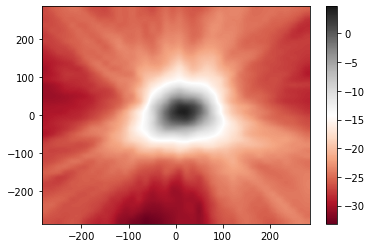

In [50]:
num_grid = xx.shape[0]
measure = G.reshape(num_grid, num_grid)
plt.imshow(measure,
           interpolation='gaussian',
           origin='lower',
           extent=(-side, side,
                   -side, side),
           cmap=plt.cm.RdGy,
           aspect='auto')
plt.colorbar()

In [1]:
zs = np.array(zs)
zs = zs[:,0]

NameError: name 'zs' is not defined

In [16]:
# Compute statistics of the latent space distribution (to guide optimization initialization)
zs_mean = np.mean(zs, axis=0)
zs_std = np.std(zs, axis=0)
zs_mean.shape, zs_std.shape  # e.g., (1, 30) for both mean and std

((30,), (30,))

## Evolution Strategy Setup

In [186]:
# Set up Evolutionary Optimizers for latent-space search (GA, CMA-ES, PEPG, OpenAI-ES)
NPOPULATION = 51  # Population size for the evolutionary algorithms (number of candidate solutions per generation)

solvers_dict = {
    'ga': SimpleGA(nz,                # number of parameters = 30 (latent vector length)
               sigma_init=0.5,        # initial mutation step size
               popsize=NPOPULATION,   # number of candidates in each generation
               elite_ratio=0.1,       # fraction of top individuals to carry to next generation (selection pressure)
               forget_best=False,     # whether to remember the best individual found so far
               weight_decay=0.00),    # no weight decay (not relevant for latent vector optimization)
    
    'cmaes': CMAES(nz,
              popsize=NPOPULATION,
              weight_decay=0.0,
              sigma_init = np.mean(zs_std),  # start CMA-ES search radius ~ average std of latent dims (a reasonable scale)
              x0 = zs_mean,                 # start search centered at the mean latent vector (average geology)
              bounds = [-150, 150]          # restrict latent values within [-150, 150] range to avoid extreme out-of-bounds
          ),
    
    'pepg': PEPG(nz,                         # PEPG = Parameter-Exploring Policy Gradients, another evolution strategy
            sigma_init=0.5,
            learning_rate=0.1, 
            learning_rate_decay=1.0,         # no decay on learning rate
            popsize=NPOPULATION,
            average_baseline=False,
            weight_decay=0.00,
            rank_fitness=False, 
            forget_best=False),
    
    'openai': OpenES(nz,                     # OpenAI-ES (another variation of evolution strategy)
            sigma_init=0.5,
            sigma_decay=0.999,
            learning_rate=0.1,
            learning_rate_decay = 1.0,
            popsize=NPOPULATION,
            antithetic=False,
            weight_decay=0.00,
            rank_fitness=False,
            forget_best=False)
}

(25_w,51)-aCMA-ES (mu_w=14.2,w_1=13%) in dimension 30 (seed=283031, Tue Jun 14 18:39:44 2022)


## load t-nav sim model objectiove function calculation

In [187]:
# Define system commands and helper functions for running reservoir simulations (tNavigator) and processing results
import math
command = 'tNav\\tNavigator-con.exe tNav\\GWAE_sim\\VAR_1.DATA --ecl-rsm > log.txt 2>&1'
# ^ Command to run TNavigator reservoir simulator in console mode on the model (redirecting output to log.txt)

def save_poro(poro):
    # Save a porosity array into the simulator's input file (GRDECL format)
    df = pd.read_csv('tNav/GWAE_sim/VAR_1_PROP_PORO.GRDECL', sep='\\t', header=None)
    poro = poro.flatten()
    k = 11  # starting line index in the GRDECL file where data values begin
    for i in range(math.ceil(len(poro)/100)):  # GRDECL lists 100 values per line
        df.loc[k] = '  ' + ' '.join([str(x) for x in poro[i*100:(i+1)*100]])
        k += 1
    df = df[:k]
    df.to_csv('tNav/GWAE_sim/VAR_1_PROP_PORO.GRDECL', sep='\\t', index=False, header=None)

def save_perm(perm):
    # Save a permeability array into the simulator's input file (GRDECL format)
    df = pd.read_csv('tNav/GWAE_sim/VAR_1_PROP_PERMX.GRDECL', sep='\\t', header=None)
    perm = perm.flatten()
    k = 11
    for i in range(math.ceil(len(perm)/100)):
        df.loc[k] = '  ' + ' '.join([str(x) for x in perm[i*100:(i+1)*100]])
        k += 1
    df = df[:k]
    df.to_csv('tNav/GWAE_sim/VAR_1_PROP_PERMX.GRDECL', sep='\\t', index=False, header=None)

def run_model():
    # Execute the simulation by calling the external simulator command
    os.system(command)

def read_result():
    # Parse the simulator output (Results file) to extract time-series data for wells
    with open('tNav/GWAE_sim/RESULTS/VAR_1.RSM', 'r') as f:    
        result_df = f.readlines()
    all_df = pd.DataFrame()
    i = 0
    while i < len(result_df):
        string = result_df[i]
        if 'TIME' in string:
            # Found a block with header columns
            cols = []
            for j in range(10):
                cols.append(string[j*13:(j+1)*13].strip())  # columns have fixed width 13 in RSM
            # Skip lines until we hit the separator line of dashes
            while not '-' in string:
                i += 1
                string = result_df[i]
            # The line 3 lines above the separator contains well identifiers
            wells = []
            for j in range(10):
                wells.append(result_df[i-3][j*13:(j+1)*13].strip())
            i += 1
            # Build full column names combining metric and well (e.g., "WOPR_P2")
            for j in range(len(cols)):
                cols[j] = cols[j] + '_' + wells[j]
            cols = np.array(cols)[np.array(cols) != '_']  # remove any empty columns
            # Read data lines until termination line (----) 
            vals = []
            string = result_df[i]
            while not '-----' in string:
                vals.append(np.array([x for x in string.split(' ') if x != '']))
                i += 1
                if i >= len(result_df):
                    vals.append([])
                    break
                string = result_df[i]
            vals = np.array(vals[:-1])[:, :-1]  # convert to array and drop the last empty column
            temp_df = pd.DataFrame(vals, columns=cols)
            all_df = pd.concat([all_df, temp_df], axis=1)  # concatenate all well data
        i += 1
    return all_df

## Simulation Setup for History Matching

In [188]:
import io as file_io
from data import OneDim_to_ThreeDim_Converter

def cut_off(poro, perm, cut_poro):
    
    #print('do', poro)
    min_poro = poro.min()
    min_perm = perm.min()

    indx = np.where(poro<cut_poro)
    poro[indx[0]] = min_poro
    perm[indx[0]] = min_perm
    #print('posle', poro)
    return poro, perm


def get_val_coords(x, y, n, m, z, data, idx2idx):
    coords = []
    vals = []
    x-=1
    y-=1
    for zz in range(z):
        if (idx2idx[zz,x,y] != -1):
            coords.append(idx2idx[zz,x,y])
            vals.append(torch.tensor(data[idx2idx[zz,x,y]]))
    
    return torch.tensor(coords), torch.stack(vals)

def get_index_list():
    mask_path = path_prefix + 'Facies.csv'        
    mask = pd.read_csv(mask_path)
    mask = pd.DataFrame(mask.iloc[:,0]).to_numpy().reshape(1, -1)
    index_list = np.argwhere(mask[0] == -1).reshape(1, -1)[0]
    
def get_misfit(pred_graph, return_result=False):
    try:
        results = {}
        misfit = []
        poro_list = pred_graph[:,0].cpu().detach().numpy()
        poro_list = np.concatenate([[0], poro_list])
        poro_list*=max_poro
        poro_list[poro_list < 0] = 0
        perm_list = transformer.inverse_transform(np.expand_dims(pred_graph[:, 1].cpu().detach().numpy(),1))
        perm_list=perm_list.flatten()
        perm_list = np.concatenate([[0], perm_list]) #add NULL cell (1,1,1) to grid
        perm_list[perm_list < 0] = 0
        
        poro_list, perm_list = cut_off(poro_list, perm_list, cut_poro = 0.05)
        
        save_poro(poro_list)    
        save_perm(perm_list)
        run_model()
        res = read_result()
        for key in BASE_KEYWORDS:
            for col in res.columns:
                if col.startswith(key):
                    misfit.append((res[col].values.astype(float)-BASE_RES[col].values.astype(float))**2)
                    results[col]=[res[col].values.astype(float),BASE_RES[col].values.astype(float)]
        if return_result:
            return np.mean(misfit), results
        return np.mean(misfit)
    except Exception as e:
        print(e)
        return 1000


from joblib import Parallel, delayed
import multiprocessing
num_cores = multiprocessing.cpu_count()

    
def fit_func(z, trainer, coords, vals):
    z = torch.reshape(torch.tensor(z), (1,30)).to(device).float()
    x, _ = trainer.model.decode(z, False)
    x = x.reshape(nv, -1)
    metric = get_measure(z, trainer)/100
    return -((vals - x[coords])**2).sum(-1).sum(-1).detach().cpu(), -metric, -get_misfit(x)

def find_solution(solver, max_iter, trainer, coords, vals, lazy_start = [0]): #функция процесса оптимизации 18.04
  history = []
  try:
      for j in tqdm(range(max_iter)):
        if j == 0 and len(lazy_start) > 1:
            solutions = lazy_start
        else:
            solutions = solver.ask()
        fitness_list = np.zeros(solver.popsize)
        mses = []
        metrics = []
        misfits = []
        k = 0
        for solution in tqdm(solutions, position=0, leave=True):
            mse, metric, misfit = fit_func(solution, trainer, coords, vals)  
            mses.append(mse)
            metrics.append(metric)
            misfits.append(misfit)
            fitness_list[k] = mse+metric+misfit
            k+=1

        wandb_run.log({
            'total_fitnes': np.mean(mses)+np.mean(metrics)+np.mean(misfits),
            'mse_mean':np.mean(mses), #разница свойствах скважины
            'metric_mean':np.mean(metrics),
            'misfit_mean':np.mean(misfits), #разница в добыче
            'mse_max':np.max(mses),
            'metric_max':np.max(metrics),
            'misfit_max':np.max(misfits)
        })

        solver.tell(fitness_list)
        result = solver.result() # first element is the best solution, second element is the best fitness
        history.append(result[1])
        np.save(f'zstep{j}', result[0])
        if (j+1) % 10 == 0:
          print("fitness at iteration", (j+1), result[1])
  except KeyboardInterrupt:
     return history
  print("local optimum discovered by solver:\n", result[0])
  print("fitness score at this local optimum:", result[1])
  return history

In [189]:
dic = {}

with open('tNav/GWAE_sim/VAR_1_SCH.INC') as f: #чтение шедул файла. Тут смотрим где расположены скважины 18.04
    reading = False
    for line in f.readlines():
        if line.startswith('COMPDAT'):
            reading = True
            continue
        if reading:
            if line.strip().startswith('/'):
                break
            linearray = line.strip().split(' ')
            if len(linearray) < 3:
                break
            dic[linearray[0]] = (linearray[1], linearray[2])

In [190]:
with open('tNav/GWAE_sim/VAR_1.DATA') as f:
    reading = False
    for line in f.readlines():
        if line.startswith('DIMENS'):
            reading = True
            continue
        if reading:
            linearray = line.strip().split(' ')
            n = int(linearray[0])
            m = int(linearray[1])
            z = int(linearray[2])
            break      

In [191]:
grid_number = 1945  # Choose a specific scenario index from the dataset as the "true" scenario for history matching

# Prepare lists of well coordinates from dic
xs = []
ys = []
for key in dic:
    xs.append(int(dic[key][0]))
    ys.append(int(dic[key][1]))

# Build an index mapping for active cells in this scenario
mask_path = path_prefix + 'Facies.csv'
mask = pd.read_csv(mask_path)
mask = pd.DataFrame(mask.iloc[:, grid_number]).to_numpy().reshape(1, -1)
index_list = np.argwhere(mask[0] == -1).reshape(1, -1)[0]  # indices of cells that are inactive (facies = -1) in this scenario

# Create a 3D array mapping (z, x, y) -> active node index for this scenario
k = 0
kk = 0
idx2idx = (np.ones((z, n, m)) * -1).astype(int)  # initialize with -1 for all (layer, i, j)
for zz in range(z):
    for yy in range(m):
        for xx in range(n):
            if k not in index_list:        # if the current cell index is active in this scenario
                idx2idx[zz, xx, yy] = kk   # map this (z,x,y) to the next active node index
                kk += 1
            k += 1

# Get actual indices and values of the chosen scenario at well locations
coords = []
vals = []
for i in range(len(xs)):
    coord, val = get_val_coords(xs[i], ys[i], n, m, z, dataset_list[grid_number].x, idx2idx)
    coords.append(coord)
    vals.append(val)
coords = torch.cat(coords, axis=0).long()   # concatenate all well cells' indices
vals = torch.cat(vals, axis=0)              # concatenate all well cells' feature vectors (poro, perm) from the true scenario

<ipython-input-188-efc327615476>:25: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  vals.append(torch.tensor(data[idx2idx[zz,x,y]]))


In [192]:
# Prepare base scenario's petrophysical properties and run a simulation to obtain "observed" production data
max_poro = max0.numpy() 

# Reconstruct porosity and permeability for the base scenario in real units
poro = dataset_list[grid_number].x[:,0].cpu().detach().numpy() * max_poro  # first feature = normalized porosity, convert back
poro = np.concatenate([[0], poro])             # prepend dummy index 0 (to align with 1-indexed cells for simulator)
poro[poro < 0] = 0                             # ensure no negative porosity
perm = transformer.inverse_transform(np.expand_dims(dataset_list[grid_number].x[:,1].cpu().detach().numpy(), 1))
perm = perm.flatten()
perm = np.concatenate([[0], perm])             # prepend dummy 0 for permeability
perm[perm < 0] = 0

BASE_PORV = np.sum(poro)  # calculate total pore volume (for info/verification)
poro, perm = cut_off(poro, perm, cut_poro = 0.05)  # apply porosity cutoff (remove cells below 5% porosity)

# Save this scenario's properties to file and run the simulator
save_poro(poro)
save_perm(perm)
run_model()
BASE_RES = read_result()
BASE_KEYWORDS = ['WOPR', 'WWPR', 'WWIR']

In [76]:
MAX_ITERATION = 10 
method = 'cmaes'
hist_cmaes = find_solution(solvers_dict[method], MAX_ITERATION, trainer, coords.long(), vals)

100%|███████████████████████████████████████████████████████████████████████████████████| 1/1 [06:34<00:00, 394.79s/it]

local optimum discovered by solver:
 [  24.63706189  -64.34616437  -27.10289656   -1.36522039  114.44236963
   60.81281925   86.34349881 -146.854415   -115.24889638   52.5731032
  -25.44695474  127.08199195    5.26264851  -11.59975246   44.483284
   71.126727    -77.28737025 -125.35738909  -30.90557157   21.91430161
   66.88098171   19.68744733 -137.4995638   127.4688565  -148.81384404
   95.67463011   25.00865676  -30.98205801  131.15019507   82.83591181]
fitness score at this local optimum: -62.445674896240234


In [77]:
solutions = solvers_dict[method].ask()

In [78]:
rewards = []
for i in tqdm(range(NPOPULATION)):
    mse, metric, misfit = fit_func(solutions[i], trainer, coords.long(), vals)
    rewards.append((mse+metric+misfit).item())
rewards = np.array(rewards)

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [06:27<00:00,  7.60s/it]


In [79]:
best_solutions = solutions[np.argsort(rewards)[::-1][:int(NPOPULATION*0.2)]]

In [195]:
result = best_solutions[0]
#result = zs[1945]

In [196]:
x_res, _ = trainer.model.decode(torch.reshape(torch.tensor(result).to(device).float(), (1,30)), False) 
x_res = x_res[0]

In [197]:
x_res = x_res.reshape((nv, -1))

In [198]:
z = torch.reshape(torch.tensor(result), (1,30)).to(device).float()
x, _ = trainer.model.decode(z, False)
x = x.reshape(nv, -1)
misfit, results = get_misfit(x, True)

In [199]:
x_G_graph = unnormalize_graph(x_res, max0, transformer)

pred_graph_geodesic = Data(x=x_G_graph, label=dataset_list[0].label, edge_index=dataset_list[0].edge_index)
Graph_to_Grid(path_prefix+'Facies.csv', pred_graph_geodesic, 0, 'poro', path_prefix+'Generated_grids\\','_Geodesic_'+'poro')
Graph_to_Grid(path_prefix+'Facies.csv', pred_graph_geodesic, 1, 'perm', path_prefix+'Generated_grids\\','_Geodesic_'+'perm')

you can find your file here: ../DATA/3_types_of_channels_with_stats/Generated_grids\
you can find your file here: ../DATA/3_types_of_channels_with_stats/Generated_grids\


In [80]:
#достаю гидродинамические расчеты для начальной популяции (нужно для статьи на экмор)
init_simulations_P2_O = []
init_simulations_P2_W = []
init_simulations_I2 = []
init_simulations_I5 = []

for i in tqdm(range(len(best_solutions))):
    z = torch.reshape(torch.tensor(best_solutions[i]), (1,30)).to(device).float()
    x, _ = trainer.model.decode(z, False)
    x = x.reshape(nv, -1)
    misfit, results = get_misfit(x, True)
    for key in results:
        if key == 'WOPR_P2':
            init_simulations_P2_O.append(results[key][0])
        if key == 'WWPR_P2':
            init_simulations_P2_W.append(results[key][0])
        if key == 'WWIR_I2':
            init_simulations_I2.append(results[key][0])
        if key == 'WWIR_I5':
            init_simulations_I5.append(results[key][0])            
    #init_simulations.append(results[0])

100%|██████████████████████████████████████████████████████████████████████████████████| 51/51 [06:25<00:00,  7.55s/it]


In [81]:
#записываю гидродинамические расчеты для начальной популяции в файлы (нужно для статьи на экмор)
folder = 4
df = pd.DataFrame(init_simulations_P2_O)
df.to_excel(excel_writer = path_prefix + '1945_grid_results/1_well_set/' + str(folder) + "/init_ensemble_WOPR_P2.xlsx")
df = pd.DataFrame(init_simulations_P2_W)
df.to_excel(excel_writer = path_prefix + '1945_grid_results/1_well_set/' + str(folder) + "/init_ensemble_WWPR_P2.xlsx")
df = pd.DataFrame(init_simulations_I2)
df.to_excel(excel_writer = path_prefix + '1945_grid_results/1_well_set/' + str(folder) + "/init_ensemble_WWIR_I2.xlsx")
df = pd.DataFrame(init_simulations_I5)
df.to_excel(excel_writer = path_prefix + '1945_grid_results/1_well_set/' + str(folder) + "/init_ensemble_WWIR_I5.xlsx")

In [51]:
pd.DataFrame.from_dict(results).to_pickle("./1945_productions_opt_and_ref.pickle") #0 set - optimized, 1 set - referece

In [52]:
pd.DataFrame.from_dict(result).to_pickle("./1945_latent_code.pickle")

In [89]:
unpickled_df = pd.read_pickle(path_prefix + '1945_grid_results/1_well_set/4/' + "1945_productions_opt_and_ref.pickle")

In [93]:
#np.savetxt("WWIR_I5.txt", unpickled_df['WWIR_I5'],fmt='%s') 
df = pd.DataFrame(unpickled_df['WOPR_P2'])
df.to_excel(excel_writer = path_prefix + '1945_grid_results/1_well_set/4/' + "WOPR_P2.xlsx")

In [111]:
#t-sne dimensionality reduction

import time
from sklearn.manifold import TSNE

#t-sne in 2D

time_start = time.time()
tsne = TSNE(n_components=3, verbose=1, perplexity=5, n_iter=300)
tsne_results = tsne.fit_transform(sss_and_1945)

print ('t-SNE done! Time elapsed: {} seconds'.format(time.time()-time_start))

[t-SNE] Computing 16 nearest neighbors...
[t-SNE] Indexed 5005 samples in 0.019s...
[t-SNE] Computed neighbors for 5005 samples in 1.106s...
[t-SNE] Computed conditional probabilities for sample 1000 / 5005
[t-SNE] Computed conditional probabilities for sample 2000 / 5005
[t-SNE] Computed conditional probabilities for sample 3000 / 5005
[t-SNE] Computed conditional probabilities for sample 4000 / 5005
[t-SNE] Computed conditional probabilities for sample 5000 / 5005
[t-SNE] Computed conditional probabilities for sample 5005 / 5005
[t-SNE] Mean sigma: 38.259051
[t-SNE] KL divergence after 250 iterations with early exaggeration: 90.771584
[t-SNE] KL divergence after 300 iterations: 2.733488
t-SNE done! Time elapsed: 7.0453245639801025 seconds


In [112]:
np.savetxt("x.txt", [tsne_results[:,0]], fmt='%1.3f', delimiter=",")
np.savetxt("y.txt", [tsne_results[:,1]], fmt='%1.3f', delimiter=",")
np.savetxt("z.txt", [tsne_results[:,2]], fmt='%1.3f', delimiter=",")

wandb: Network error resolved after 0:17:04.012513, resuming normal operation.


In [1]:
#подгружаю вариант оптимизации для любого шага
some_solution = np.load('zstep0.npy') #загрузка из np

NameError: name 'np' is not defined

In [37]:
df = pd.read_excel(path_prefix + '/1945_grid_results/1_well_set/' + 'Rates.xlsx', sheet_name = 'WOPR_P2',index_col=0)  


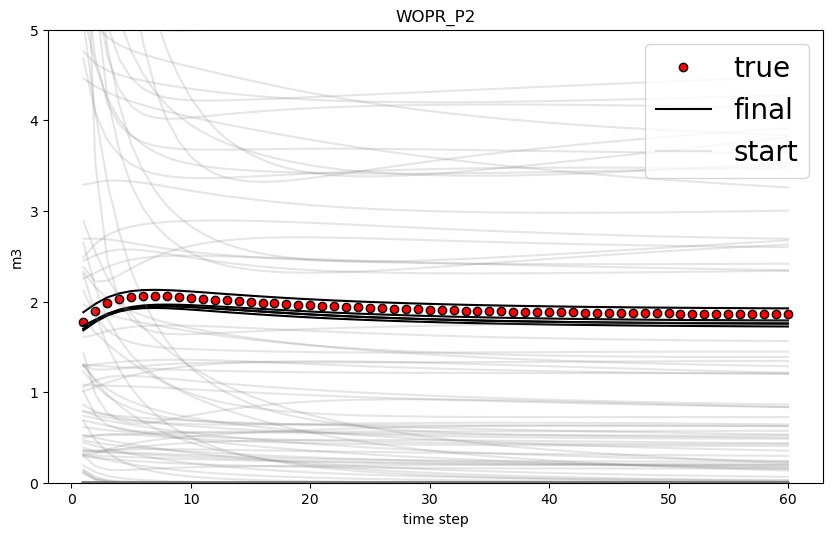

In [39]:
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure


%matplotlib inline
figure(figsize=(10, 6), dpi=100)

plt.plot(df.iloc[4], c="r", alpha=1, label="true", marker="o",mec = 'black',linestyle="None")

plt.plot(df.iloc[0].T, label="final", c="black")
plt.plot(df.iloc[0:4].T, c="black")
plt.xlabel("time step")
plt.ylabel("m3")
plt.plot(df.iloc[5].T, label="start", c="grey", alpha=0.2)
plt.plot(df.iloc[5:].T, c="grey", alpha=0.2)

plt.legend(loc='upper right', fontsize=20)
plt.ylim(0,5)
plt.title("WOPR_P2")

plt.show()